In [19]:
import requests
import pandas as pd
import json
pd_v = pd.__version__
python_v = !python -V
print("version", *python_v)
print("version Pandas", pd_v)
print("version Requests", requests.__version__)

version Python 3.10.5
version Pandas 2.0.2
version Requests 2.26.0


**Входные данные**

In [21]:
url = 'https://rss.applemarketingtools.com/api/v2/ru/apps/top-paid/100/apps.json'
response = requests.get(url)
response.status_code

200

**Решение**

In [22]:
top_app_json = json.loads(response.text)
#top_app_json['feed']['results']

In [29]:
# Получаем все атрибуты
top_app_set = set()
genre_set = set()
# На случай если есть разное кол-во атрибутов или их имен проходимся по всему датасету
for i in top_app_json['feed']['results']:
    if isinstance(i, dict):
        top_app_set.update(set(i.keys()))
    if len(i['genres']) > 0 and isinstance(i['genres'], list):
        for j in i['genres']:
            if isinstance(j, dict):
                genre_set.update(set(j.keys()))
print("Аpplication attributes:", top_app_set)
print("Genre attributes:", genre_set)

Аpplication attributes: {'artworkUrl100', 'artistName', 'genres', 'name', 'url', 'releaseDate', 'id', 'kind'}
Genre attributes: {'genreId', 'name', 'url'}


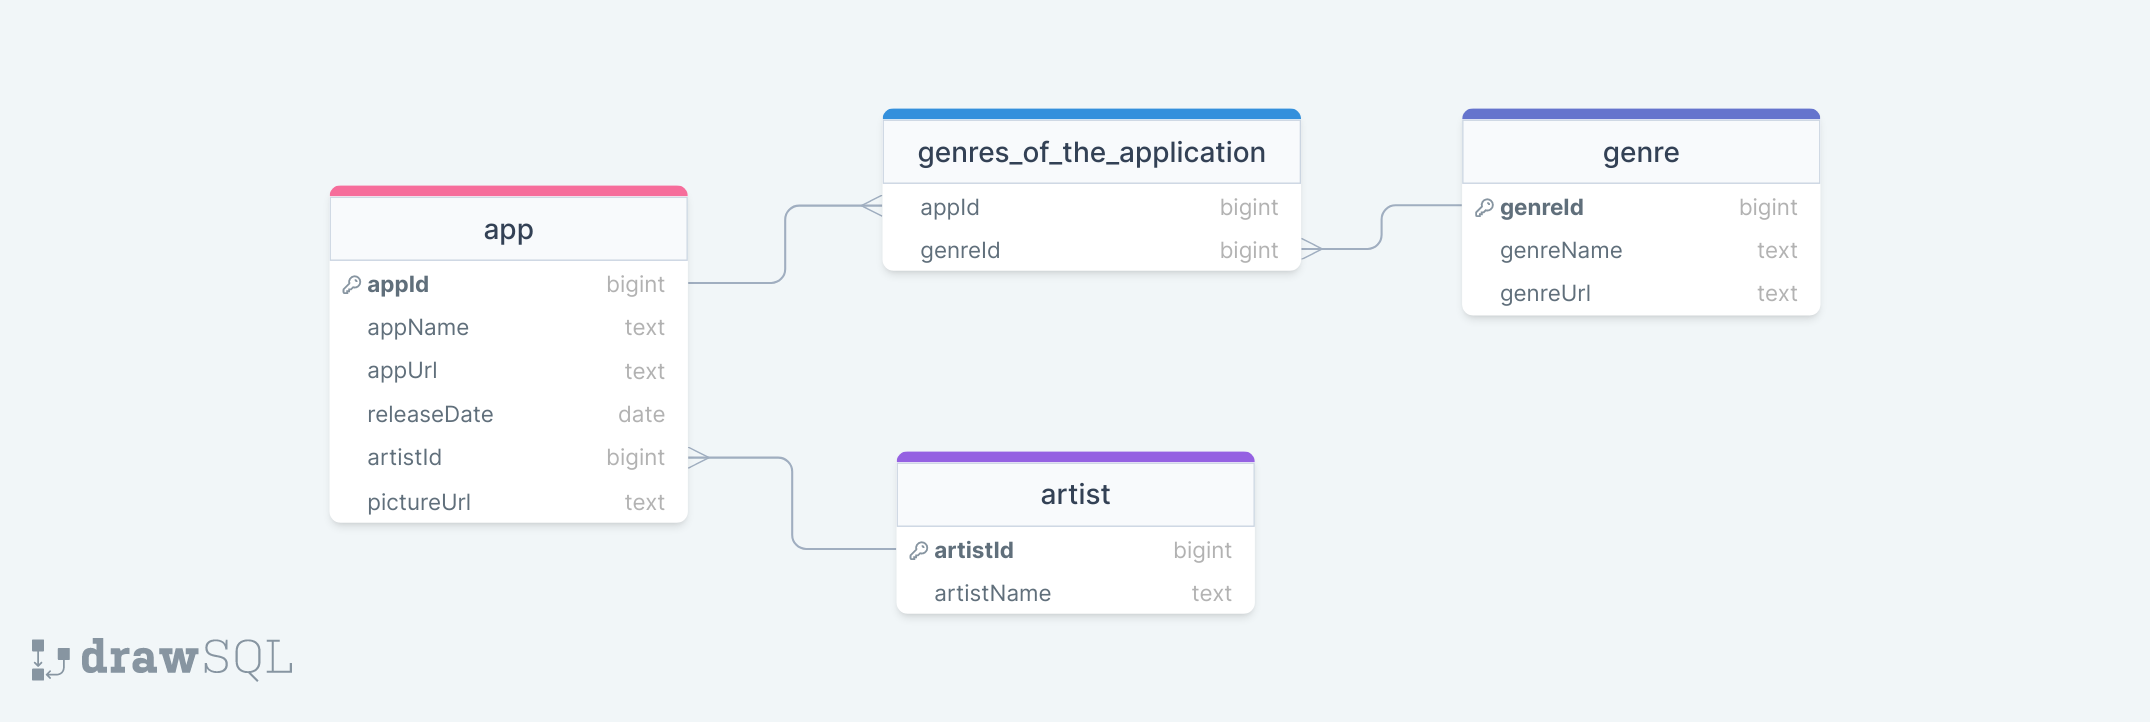

In [36]:
# Заготовка для всех сущностей
df = pd.read_json(response.text, orient='index')
df = df.results.explode('results').reset_index(drop=True)
df = pd.DataFrame(df.to_list(), columns = list(top_app_set))
df.sample(5)

,artworkUrl100,artistName,genres,name,url,releaseDate,id,kind
39,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,Image Line Software,"[{'genreId': '6011', 'name': 'Музыка', 'url': ...",FL Studio Mobile,https://apps.apple.com/ru/app/fl-studio-mobile...,2011-06-21,432850619,apps
66,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,Fitness Guide Inc,"[{'genreId': '6013', 'name': 'Здоровье и фитне...",7 Minute Workout Challenge,https://apps.apple.com/ru/app/7-minute-workout...,2013-07-30,680170305,apps
23,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,Qneo,"[{'genreId': '6016', 'name': 'Развлечения', 'u...",Blower,https://apps.apple.com/ru/app/blower/id335862325,2009-11-14,335862325,apps
2,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,Vitaly Shmuradko,[],Антирадар Стрелка,https://apps.apple.com/ru/app/%D0%B0%D0%BD%D1%...,2013-04-20,606147643,apps
28,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,Alexander Kondrashov,"[{'genreId': '6017', 'name': 'Образование', 'u...",Урок Слов,https://apps.apple.com/ru/app/%D1%83%D1%80%D0%...,2012-02-23,498934007,apps


In [37]:
# Значение kind для всех одно (apps), его не включаем в атрибуты
print(df.kind.unique())

['apps']


In [38]:
#Cущность - автор (поля: artistId, artistName)
df_artist = pd.DataFrame(df.artistName.unique(), columns=['artistName'])
df_artist = df_artist.dropna()
df_artist['artistId'] = range(1, len(df_artist) + 1)
df_artist.sample(5)

,artistName,artistId
65,David Quiles,66
61,yicai yang,62
44,EPLAYWORKS,45
10,Roman Kuryanov,11
11,Tantsissa,12


In [39]:
#Cущность - жанры приложений (поля: genreId, appId)
df_genres_app = df[['id','genres']].explode('genres').reset_index(drop=True)
df_genres_app = df_genres_app.dropna(subset=['genres'])
df_genres_app['genres'] = df_genres_app['genres'].apply(lambda x: x['genreId'])
df_genres_app.rename(columns={'genres': 'genreId',
                              'id': 'appId'}, inplace=True)
df_genres_app.sample(5)

,appId,genreId
63,963034692,6002
146,1030595027,6002
95,1126058329,6008
67,424209938,6017
69,1220141181,6012


In [40]:
#Cущность - жанр (поля: genreId, genreName, genreUrl)
df_genre = df['genres'].explode('genres').reset_index(drop=True)
df_genre = df_genre.dropna()
df_genre = pd.DataFrame(df_genre.to_list(), columns = ['genreId', 'name', 'url'])
df_genre.rename(columns={'name': 'genreName',
                        'url': 'genreUrl'}, inplace=True)
df_genre.drop_duplicates(inplace=True)
df_genre.sample(5)

,genreId,genreName,genreUrl
82,6003,Путешествия,https://itunes.apple.com/ru/genre/id6003
8,6000,Бизнес,https://itunes.apple.com/ru/genre/id6000
10,6001,Погода,https://itunes.apple.com/ru/genre/id6001
99,6004,Спорт,https://itunes.apple.com/ru/genre/id6004
9,6015,Финансы,https://itunes.apple.com/ru/genre/id6015


In [41]:
# Cущность - приложение (поля: appId, appName, appUrl, pictureUrl, releaseDate, artistId)
df_app = df.copy().drop(['genres', 'kind'], axis=1)
df_app = pd.merge(df_app, df_artist, on='artistName')
df_app.drop(['artistName'], axis=1, inplace=True)
df_app.rename(columns={'id': 'appId',
                        'name': 'appName',
                        'url': 'appUrl',
                        'artworkUrl100': 'pictureUrl'}, inplace=True)
df_app.sample(5)


,pictureUrl,appName,appUrl,releaseDate,appId,artistId
24,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,Forest - Сосредоточьтесь,https://apps.apple.com/ru/app/forest-%D1%81%D0...,2014-05-10,866450515,21
64,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,Slow Shutter Cam,https://apps.apple.com/ru/app/slow-shutter-cam...,2010-02-23,357404131,60
31,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,Урок Слов,https://apps.apple.com/ru/app/%D1%83%D1%80%D0%...,2012-02-23,498934007,28
38,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,До и После Про Слайдер,https://apps.apple.com/ru/app/%D0%B4%D0%BE-%D0...,2013-08-07,680502514,35
52,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,Color Wheel - Basic Schemes,https://apps.apple.com/ru/app/color-wheel-basi...,2015-07-02,1011534164,49
